In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
import os.path as osp
from numpy import mean
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [2]:
class LoadImageDataset(data.Dataset):
    def __init__(self, df_path, root_dir, transform=None):
        self.data = pd.read_csv(df_path)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data.iloc[index, 0])
        image = Image.open(img_path).convert('L')
        y_label = torch.tensor(int(self.data.iloc[index, 1]))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, y_label

# Try 1
## Experiment 2 on Dataset_C with given Hyperparameter,
### Batch_size = 64, Number of Iterations = 30000,  Learning Rate = 0.06, 6 Hidden Layer, 200 Unit Per Layer, Tanh Activation

In [3]:
batch_size = 64
num_iters = 30000
input_dim = 180 * 180 #num_features = 32400
output_dim = 10
learning_rate = 0.06
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = [0.5,]
std = [0.5, ]
#Load Dataset
train_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset  = LoadImageDataset(df_path = 'Dataset_C/training_minimized.csv', root_dir = 'Dataset_C/training-c', transform=train_transform)

# Split Dataset
dataset_length = len(dataset)
# indices = list(range(dataset_size))
train_dataset_length = int(dataset_length*.8)
test_dataset_length = dataset_length - train_dataset_length
train_dataset, test_dataset = data.random_split(dataset, lengths=[train_dataset_length, test_dataset_length])
print('Train dataset length: ',len(train_dataset))
print('Test dataset length: ',len(test_dataset))

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  
print(len(train_loader));
print(len(test_loader));

cuda:0
Train dataset length:  19438
Test dataset length:  4860
304
76


In [4]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.tanh_2 = nn.Tanh()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.tanh_3 = nn.Tanh()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.tanh_4 = nn.Tanh()


        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.tanh_5 = nn.Tanh()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.tanh_6 = nn.Tanh()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.tanh_1(out)

        out  = self.linear_2(out)
        out = self.tanh_2(out)

        out  = self.linear_3(out)
        out = self.tanh_3(out)

        out  = self.linear_4(out) 
        out = self.tanh_4(out)

        out  = self.linear_5(out)
        out = self.tanh_5(out)

        out  = self.linear_6(out)
        out = self.tanh_6(out)

        probas  = self.linear_out(out)
        return probas

In [5]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

C:\Users\faisa\Dev\Tools\anaconda3\envs\pyTorch190\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [ ]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 28*28).to(device) 
                # Forward pass only to get logits/output
                optimizer.zero_grad()
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

In [11]:
perf_measure = [[500, 2.2873549461364746, 12.263374485596708],
 [1000, 2.279599666595459, 10.843621399176955],
 [1500, 2.3267383575439453, 11.54320987654321],
 [2000, 2.314850091934204, 9.876543209876543],
 [2500, 2.304370880126953, 11.152263374485596],
 [3000, 2.3010342121124268, 9.979423868312757],
 [3500, 2.3033831119537354, 9.197530864197532],
 [4000, 2.27732515335083, 9.876543209876543],
 [4500, 2.305955410003662, 9.897119341563785],
 [5000, 2.299337863922119, 13.97119341563786],
 [5500, 2.3020410537719727, 13.724279835390947],
 [6000, 2.313082218170166, 13.786008230452675],
 [6500, 2.3069076538085938, 9.876543209876543],
 [7000, 2.298924684524536, 9.876543209876543],
 [7500, 2.296346664428711, 10.061728395061728],
 [8000, 2.309401750564575, 11.604938271604938],
 [8500, 2.301783561706543, 9.48559670781893],
 [9000, 2.310727596282959, 10.041152263374485],
 [9500, 2.3028929233551025, 9.176954732510287],
 [10000, 2.301666259765625, 9.91769547325103],
 [10500, 2.2886552810668945, 11.934156378600823],
 [11000, 2.305708885192871, 9.876543209876543],
 [11500, 2.289853096008301, 9.897119341563785],
 [12000, 2.296442985534668, 9.876543209876543],
 [12500, 2.3158013820648193, 10.123456790123457],
 [13000, 2.2977921962738037, 9.897119341563785],
 [13500, 2.2967207431793213, 10.020576131687243],
 [14000, 2.302753210067749, 9.48559670781893],
 [14500, 2.310540199279785, 10.493827160493828],
 [15000, 2.274733304977417, 13.477366255144032],
 [15500, 2.2781829833984375, 9.897119341563785],
 [16000, 2.29284405708313, 9.48559670781893],
 [16500, 2.3167991638183594, 10.061728395061728],
 [17000, 2.3071630001068115, 10.329218106995885],
 [17500, 2.3170924186706543, 10.925925925925926],
 [18000, 2.3190665245056152, 9.8559670781893],
 [18500, 2.310912609100342, 10.329218106995885],
 [19000, 2.2800559997558594, 9.897119341563785],
 [19500, 2.298556327819824, 10.411522633744855],
 [20000, 2.301182270050049, 10.2880658436214],
 [20500, 2.3065052032470703, 9.506172839506172],
 [21000, 2.3080332279205322, 11.563786008230453],
 [21500, 2.299351692199707, 11.54320987654321],
 [22000, 2.298532247543335, 13.518518518518519],
 [22500, 2.3048274517059326, 9.48559670781893],
 [23000, 2.2942888736724854, 12.427983539094651],
 [23500, 2.3040947914123535, 10.0],
 [24000, 2.297395944595337, 9.876543209876543],
 [24500, 2.2994463443756104, 9.897119341563785],
 [25000, 2.3042123317718506, 10.0],
 [25500, 2.3141977787017822, 9.835390946502057],
 [26000, 2.3253772258758545, 9.938271604938272],
 [26500, 2.3017921447753906, 9.91769547325103],
 [27000, 2.299560546875, 9.897119341563785],
 [27500, 2.314445972442627, 10.061728395061728],
 [28000, 2.285399913787842, 9.91769547325103],
 [28500, 2.3023788928985596, 9.876543209876543],
 [29000, 2.307612895965576, 10.267489711934155],
 [29500, 2.299548387527466, 9.465020576131687]]

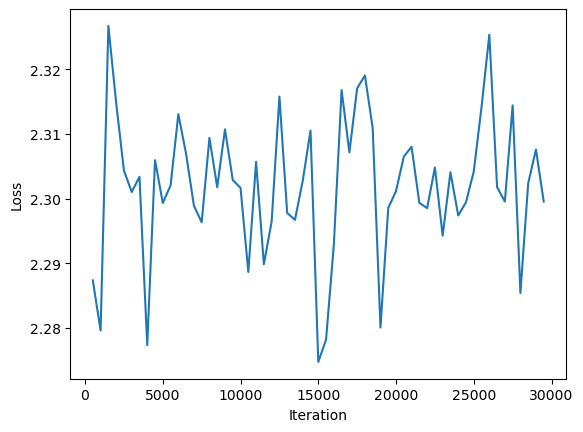

In [12]:
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Try1.png')
plt.show()

# Try 2
## Experiment 2 on Dataset_C with given Hyperparameter,
### Batch_size = 128, Number of Iterations = 50000,  Learning Rate = 0.06, 4 Hidden Layer, 200 Unit Per Layer, ReLU Activation

In [ ]:
batch_size = 128
num_iters = 50000
input_dim = 180 * 180 #num_features = 32400
output_dim = 10
learning_rate = 0.06
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = [0.5,]
std = [0.5, ]
#Load Dataset
train_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset  = LoadImageDataset(df_path = 'Dataset_C/training_minimized.csv', root_dir = 'Dataset_C/training-c', transform=train_transform)

# Split Dataset
dataset_length = len(dataset)
# indices = list(range(dataset_size))
train_dataset_length = int(dataset_length*.8)
test_dataset_length = dataset_length - train_dataset_length
train_dataset, test_dataset = data.random_split(dataset, lengths=[train_dataset_length, test_dataset_length])
print('Train dataset length: ',len(train_dataset))
print('Test dataset length: ',len(test_dataset))

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  
print(len(train_loader));
print(len(test_loader));

In [ ]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.activation_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.activation_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.activation_4 = nn.ReLU()


        ### Output layer
        self.linear_out = nn.Linear(200, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.activation_1(out)

        out  = self.linear_2(out)
        out = self.activation_2(out)

        out  = self.linear_3(out)
        out = self.activation_3(out)

        out  = self.linear_4(out) 
        out = self.activation_4(out)


        probas  = self.linear_out(out)
        return probas

In [ ]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 180*180).to(device) 
                # Forward pass only to get logits/output
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

In [8]:
perf_measure = [[500,2.3340024948120117,15.246913580246913],
[1000,2.198972463607788,19.17695473251029],
[1500,2.3423852920532227,10.925925925925926],
[2000,2.4015913009643555,10.020576131687243],
[2500,2.3299765586853027,15.946502057613168],
[3000,2.4136080741882324,16.604938271604937],
[3500,2.211127281188965,17.757201646090536],
[4000,2.014600992202759,22.11934156378601],
[4500,2.5831785202026367,16.46090534979424],
[5000,1.9573490619659424,24.032921810699587],
[5500,2.039039373397827,16.707818930041153],
[6000,1.9105949401855469,27.901234567901234],
[6500,1.947450876235962,27.613168724279834],
[7000,1.9255456924438477,29.609053497942387],
[7500,2.280080795288086,26.85185185185185],
[8000,1.8067717552185059,37.22222222222222],
[8500,1.8843621015548706,30.20576131687243],
[9000,1.839901328086853,35.74074074074074],
[9500,1.9167888164520264,33.641975308641975],
[10000,1.8326358795166016,41.193415637860085],
[10500,1.807471752166748,40.55555555555556],
[11000,1.7521651983261108,34.32098765432099],
[11500,1.5470091104507446,37.44855967078189],
[12000,1.636223316192627,43.18930041152263],
[12500,1.6700931787490845,45.63786008230453],
[13000,1.432844638824463,46.70781893004115],
[13500,1.4947144985198975,37.86008230452675],
[14000,1.6107659339904785,48.991769547325106],
[14500,1.5599963665008545,49.300411522633745],
[15000,1.4095664024353027,45.5761316872428],
[15500,1.5959594249725342,39.75308641975309],
[16000,1.2343792915344238,42.26337448559671],
[16500,1.1733837127685547,45.288065843621396],
[17000,1.4992245435714722,44.32098765432099],
[17500,1.5100723505020142,46.48148148148148],
[18000,1.3043456077575684,53.29218106995885],
[18500,1.2476178407669067,47.65432098765432],
[19000,1.258765459060669,48.97119341563786],
[19500,1.4842908382415771,44.876543209876544],
[20000,1.3162508010864258,50.864197530864196],
[20500,1.2245733737945557,56.21399176954733],
[21000,1.6314302682876587,46.99588477366255],
[21500,1.426679015159607,50.781893004115226],
[22000,1.1620527505874634,53.16872427983539],
[22500,1.4934459924697876,50.7201646090535],
[23000,0.9767192006111145,58.02469135802469],
[23500,1.0502777099609375,54.2798353909465],
[24000,1.2557332515716553,50.699588477366255],
[24500,1.1268539428710938,56.522633744855966],
[25000,1.1425559520721436,47.94238683127572],
[25500,1.2799057960510254,55.946502057613166],
[26000,1.196895956993103,55.76131687242798],
[26500,1.0491169691085815,55.51440329218107],
[27000,1.1192265748977661,54.17695473251029],
[27500,1.3730876445770264,57.016460905349795],
[28000,1.0295534133911133,40.452674897119344],
[28500,1.5235918760299683,49.50617283950617],
[29000,0.9241394996643066,55.80246913580247],
[29500,0.9883385300636292,55.24691358024691],
[30000,1.0952907800674438,51.06995884773662]]

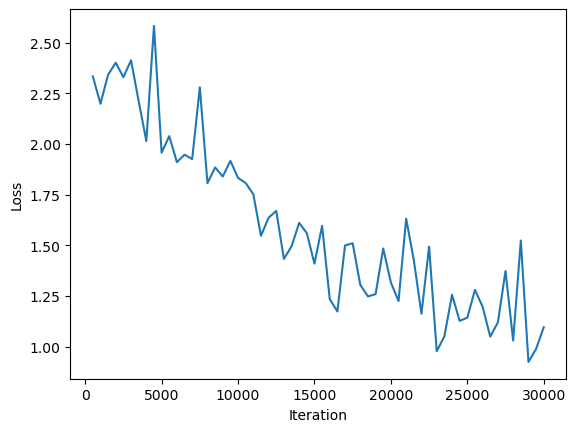

In [10]:
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Try2.png')
plt.show()

# Try 3
## Experiment 2 on Dataset_C with given Hyperparameter,
### Batch_size = 128, Number of Iterations = 50000,  Learning Rate = 0.05, 6 Hidden Layer, 200 Unit Per Layer, ReLU Activation

In [ ]:
batch_size = 128
num_iters = 50000
input_dim = 180 * 180 #num_features = 32400
output_dim = 10
learning_rate = 0.05
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mean = [0.5,]
std = [0.5, ]
#Load Dataset
train_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset  = LoadImageDataset(df_path = 'Dataset_C/training_minimized.csv', root_dir = 'Dataset_C/training-c', transform=train_transform)

# Split Dataset
dataset_length = len(dataset)
# indices = list(range(dataset_size))
train_dataset_length = int(dataset_length*.8)
test_dataset_length = dataset_length - train_dataset_length
train_dataset, test_dataset = data.random_split(dataset, lengths=[train_dataset_length, test_dataset_length])
print('Train dataset length: ',len(train_dataset))
print('Test dataset length: ',len(test_dataset))

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  
print(len(train_loader));
print(len(test_loader));

In [ ]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.activation_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.activation_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.activation_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.activation_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.activation_6 = nn.ReLU()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.activation_1(out)

        out  = self.linear_2(out)
        out = self.activation_2(out)

        out  = self.linear_3(out)
        out = self.activation_3(out)

        out  = self.linear_4(out) 
        out = self.activation_4(out)

        out  = self.linear_5(out)
        out = self.activation_5(out)

        out  = self.linear_6(out)
        out = self.activation_6(out)

        probas  = self.linear_out(out)
        return probas

In [ ]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 180*180).to(device) 
                # Forward pass only to get logits/output
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

In [13]:
perf_measure = [[500,2.303729772567749,10.123456790123457],
[1000,2.290722608566284,11.502057613168724],
[1500,2.260794162750244,14.012345679012345],
[2000,2.254059314727783,11.522633744855968],
[2500,2.222963809967041,18.395061728395063],
[3000,2.1544792652130127,20.493827160493826],
[3500,2.2476511001586914,10.96707818930041],
[4000,2.2170615196228027,22.674897119341562],
[4500,2.1687161922454834,25.720164609053498],
[5000,2.168436288833618,22.839506172839506],
[5500,2.2884068489074707,20.679012345679013],
[6000,2.040224552154541,31.790123456790123],
[6500,1.9016432762145996,28.53909465020576],
[7000,1.922817587852478,28.45679012345679],
[7500,1.874617099761963,34.382716049382715],
[8000,2.077091932296753,25.555555555555557],
[8500,1.8033061027526855,35.74074074074074],
[9000,1.6909703016281128,30.51440329218107],
[9500,2.0660362243652344,38.39506172839506],
[10000,1.7881947755813599,38.251028806584365],
[10500,1.536716341972351,39.5679012345679],
[11000,1.7438942193984985,43.37448559670782],
[11500,1.5525163412094116,41.06995884773662],
[12000,1.812835454940796,34.83539094650206],
[12500,1.7134950160980225,45.22633744855967],
[13000,1.4535330533981323,47.325102880658434],
[13500,1.3903961181640625,47.53086419753087],
[14000,1.5118491649627686,42.510288065843625],
[14500,1.2922723293304443,51.95473251028807],
[15000,1.820170283317566,38.10699588477366],
[15500,1.9149976968765259,38.477366255144034],
[16000,1.2633644342422485,53.27160493827161],
[16500,1.4169785976409912,48.53909465020576],
[17000,0.9479034543037415,57.53086419753087],
[17500,1.0942288637161255,59.17695473251029],
[18000,0.96066814661026,60.390946502057616],
[18500,0.7423065900802612,60.041152263374485],
[19000,1.0993685722351074,55.18518518518518],
[19500,1.5641353130340576,52.53086419753087],
[20000,0.8907825946807861,65.53497942386831],
[20500,0.8411568403244019,58.93004115226338],
[21000,1.1840791702270508,57.818930041152264],
[21500,1.0545164346694946,44.32098765432099],
[22000,0.9347692131996155,69.83539094650206],
[22500,1.1545668840408325,57.88065843621399],
[23000,0.8608264327049255,59.83539094650206],
[23500,1.0971944332122803,63.8477366255144],
[24000,0.4608525037765503,73.88888888888889],
[24500,0.40510809421539307,73.88888888888889],
[25000,0.6370297074317932,69.5679012345679],
[25500,0.4403569996356964,76.74897119341564],
[26000,0.7242938280105591,67.67489711934157],
[26500,0.9903690218925476,52.88065843621399],
[27000,0.47209611535072327,75.02057613168725],
[27500,0.7281562089920044,73.95061728395062],
[28000,0.4871387481689453,74.77366255144032],
[28500,0.37529054284095764,72.36625514403292],
[29000,0.4390111565589905,73.95061728395062],
[29500,1.1204440593719482,54.053497942386834],
[30000,0.40704330801963806,77.46913580246914],
[30500,0.5637208819389343,71.23456790123457],
[31000,0.3156980276107788,78.14814814814815],
[31500,0.1875188946723938,78.66255144032922],
[32000,0.3957049548625946,77.46913580246914],
[32500,0.45787206292152405,74.25925925925925],
[33000,0.2094855159521103,79.52674897119341],
[33500,0.5397980809211731,74.36213991769547],
[34000,0.2240585833787918,78.68312757201646],
[34500,0.17966993153095245,77.07818930041152],
[35000,0.5126641392707825,68.8477366255144],
[35500,2.274263620376587,45.123456790123456],
[36000,0.19749373197555542,79.54732510288066],
[36500,0.2086925208568573,79.75308641975309],
[37000,0.4371548593044281,76.93415637860082],
[37500,0.41099148988723755,74.36213991769547],
[38000,0.2591741979122162,76.95473251028807],
[38500,0.28436926007270813,78.25102880658436],
[39000,1.1088719367980957,54.58847736625514],
[39500,0.03896833583712578,81.09053497942386],
[40000,0.04452180489897728,81.31687242798354],
[40500,0.04026748612523079,81.60493827160494],
[41000,0.10869240015745163,79.79423868312757],
[41500,0.0305336806923151,81.29629629629629],
[42000,0.04024479538202286,81.09053497942386],
[42500,0.11561428010463715,79.40329218106996],
[43000,0.23108074069023132,77.65432098765432],
[43500,0.030592167750000954,81.27572016460906],
[44000,0.023803608492016792,81.04938271604938],
[44500,0.649855375289917,72.48971193415638],
[45000,0.11901171505451202,76.83127572016461],
[45500,0.039535775780677795,80.06172839506173],
[46000,0.062221139669418335,79.65020576131687],
[46500,0.006026262883096933,81.70781893004116],
[47000,0.0015063660684973001,81.79012345679013],
[47500,0.0022170571610331535,82.20164609053498],
[48000,0.0015820275293663144,82.03703703703704],
[48500,0.0008381003863178194,81.99588477366255],
[49000,0.0005487800808623433,82.11934156378601],
[49500,0.0012270411243662238,81.95473251028807],
[50000,0.0005899984971620142,81.95473251028807]]

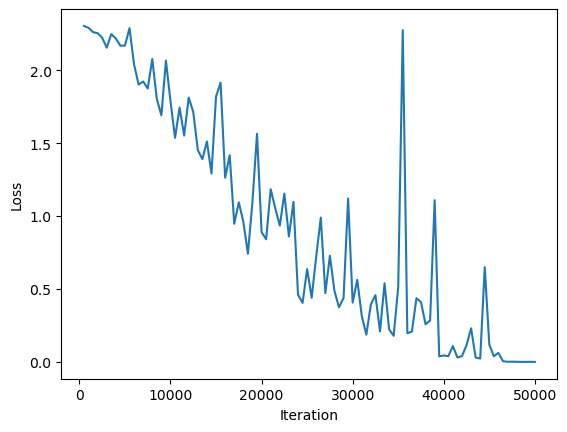

In [14]:
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Try3.png')
plt.show()

# Try 3
## Experiment 2 on Dataset_C with given Hyperparameter,
### Batch_size = 256, Number of Iterations = 50000,  Learning Rate = 0.05, 8 Hidden Layer,1000,800,600,500,400,350,200,200 Unit in per Layer ReLU Activation

In [ ]:
batch_size = 256
num_iters = 50000
input_dim = 180 * 180 #num_features = 32400
output_dim = 10
learning_rate = 0.05
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = [0.5,]
std = [0.5, ]
#Load Dataset
train_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset  = LoadImageDataset(df_path = 'Dataset_C/training_minimized.csv', root_dir = 'Dataset_C/training-c', transform=train_transform)

# Split Dataset
dataset_length = len(dataset)
# indices = list(range(dataset_size))
train_dataset_length = int(dataset_length*.8)
test_dataset_length = dataset_length - train_dataset_length
train_dataset, test_dataset = data.random_split(dataset, lengths=[train_dataset_length, test_dataset_length])
print('Train dataset length: ',len(train_dataset))
print('Test dataset length: ',len(test_dataset))

In [ ]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 1000)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(1000, 800)
        self.activation_2 = nn.ReLU()

        self.linear_3 = nn.Linear(800, 600)
        self.activation_3 = nn.ReLU()

        self.linear_4 = nn.Linear(600, 500)
        self.activation_4 = nn.ReLU()

        self.linear_5 = nn.Linear(500, 400)
        self.activation_5 = nn.ReLU()

        self.linear_6 = nn.Linear(400, 350)
        self.activation_6 = nn.ReLU()
        
        self.linear_7 = nn.Linear(350, 200)
        self.activation_7 = nn.ReLU()

        self.linear_8 = nn.Linear(200, 200)
        self.activation_8 = nn.ReLU()

        ### Output layer
        self.linear_out = nn.Linear(200, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.activation_1(out)

        out  = self.linear_2(out)
        out = self.activation_2(out)

        out  = self.linear_3(out)
        out = self.activation_3(out)

        out  = self.linear_4(out) 
        out = self.activation_4(out)

        out  = self.linear_5(out)
        out = self.activation_5(out)

        out  = self.linear_6(out)
        out = self.activation_6(out)
        
        out  = self.linear_7(out)
        out = self.activation_7(out)

        out  = self.linear_8(out)
        out = self.activation_8(out)

        probas  = self.linear_out(out)
        return probas

In [ ]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 180*180).to(device) 
                # Forward pass only to get logits/output
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])


In [ ]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(),'custom_nn.pkl')

In [15]:
perf_measure = [[1000,2.3002870082855225,9.8559670781893],
                [2000,2.301344156265259,9.567901234567902],
                [3000,2.302912712097168,9.567901234567902],
                [4000, 2.300093650817871, 9.794238683127572],
                [5000,2.258446455001831,13.662551440329219],
                [6000,2.2447354793548584,15.761316872427983],
                [7000, 2.1297950744628906,17.901234567901234],
                [8000,2.2296512126922607,19.855967078189302],
                [9000,2.2126779556274414,14.176954732510287],
                [10000,2.189554214477539,20.637860082304528],
                [11000,2.116694211959839,22.530864197530864],
                [12000,2.020660400390625,21.296296296296298],
                [13000,1.9512252807617188,23.60082304526749],
                [14000,2.0632829666137695,28.847736625514404],
                [15000,1.8621641397476196,33.251028806584365],
                [16000,1.7326332330703735,34.44444444444444],
                [17000,1.8506743907928467,37.88065843621399],
                [18000,1.7720009088516235,42.098765432098766],
                [19000,1.3934069871902466,44.958847736625515],
                [20000,1.5174137353897095, 45.49382716049383],
                [21000,1.1722674369812012,45.4320987654321],
                [22000,1.355552315711975,41.111111111111114],
                [23000,1.570696234703064,50.47325102880659],
                [24000,0.8876181244850159,61.193415637860085],
                [25000,0.8013088703155518,63.16872427983539],
                [26000,0.656424880027771,71.85185185185185],
                [27000,0.4732974171638489,72.11934156378601],
                [28000,0.6487507820129395,72.48971193415638],
                [29000,0.4809533953666687,70.90534979423869],
                [30000,0.21543870866298676,81.21399176954732],
                [31000,0.3993316888809204,76.19341563786008],
                [32000,0.11507707089185715, 83.64197530864197],
                [33000,0.06514345109462738,84.34156378600824],
                [34000,0.1418035626411438,82.81893004115226],
                [35000,0.0028858559671789408,85.26748971193416],
                [36000,0.20217694342136383,81.64609053497942],
                [37000,0.0022514769807457924,85.63786008230453],
                [38000,0.28896135091781616,80.08230452674897],
                [39000,0.0006688597495667636,85.51440329218107],
                [40000,0.0003175248275510967,85.59670781893004],
                [41000,0.00013450489495880902,85.63786008230453],
                [42000,0.0001810254470910877,85.69958847736625],
                [43000,0.00010009051766246557,85.63786008230453],
                [44000,0.00013316406693775207,85.59670781893004],
                [45000,0.0001545619306853041,85.65843621399176],
                [46000,7.379611633950844e-05,85.59670781893004],
                [47000,6.733930058544502e-05,85.59670781893004],
                [48000,5.8449011703487486e-05,85.65843621399176],
                [49000,4.958654608344659e-05,85.59670781893004],
                [50000,4.4374377466738224e-05,85.59670781893004]]

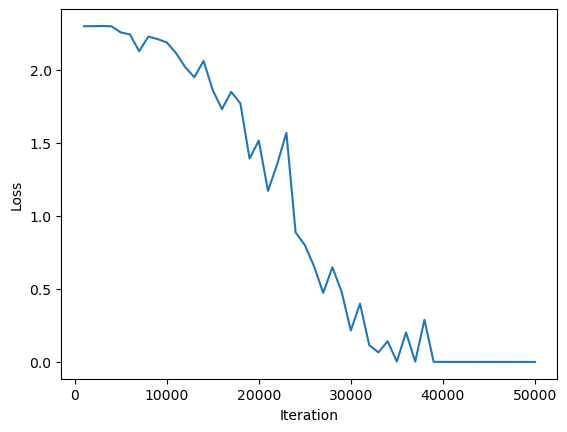

In [16]:
perf_measure
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Try4.png')
plt.show()

## Experiment 3 on Dataset_2 with given Hyperparameter,
### Batch_size = 256, Number of Iterations = 50000,  Learning Rate = 0.05, 8 Hidden Layer,1000,800,600,500,400,350,200,200 Unit in per Layer ReLU Activation

In [17]:
batch_size = 256
num_iters = 50000
input_dim = 28 * 28 #num_features = 32400
output_dim = 10
learning_rate = 0.05
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_set = datasets.FashionMNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_set = datasets.FashionMNIST(root = './data', train = False, transform = transforms.ToTensor())

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

cuda:0


C:\Users\faisa\Dev\Tools\anaconda3\envs\pyTorch190\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [18]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 1000)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(1000, 800)
        self.activation_2 = nn.ReLU()

        self.linear_3 = nn.Linear(800, 600)
        self.activation_3 = nn.ReLU()

        self.linear_4 = nn.Linear(600, 500)
        self.activation_4 = nn.ReLU()

        self.linear_5 = nn.Linear(500, 400)
        self.activation_5 = nn.ReLU()

        self.linear_6 = nn.Linear(400, 350)
        self.activation_6 = nn.ReLU()
        
        self.linear_7 = nn.Linear(350, 200)
        self.activation_7 = nn.ReLU()

        self.linear_8 = nn.Linear(200, 200)
        self.activation_8 = nn.ReLU()

        ### Output layer
        self.linear_out = nn.Linear(200, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.activation_1(out)

        out  = self.linear_2(out)
        out = self.activation_2(out)

        out  = self.linear_3(out)
        out = self.activation_3(out)

        out  = self.linear_4(out) 
        out = self.activation_4(out)

        out  = self.linear_5(out)
        out = self.activation_5(out)

        out  = self.linear_6(out)
        out = self.activation_6(out)
        
        out  = self.linear_7(out)
        out = self.activation_7(out)

        out  = self.linear_8(out)
        out = self.activation_8(out)

        probas  = self.linear_out(out)
        return probas

In [19]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 28*28).to(device) 
                # Forward pass only to get logits/output
                optimizer.zero_grad()
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

Iteration: 500. Loss: 0.9713074564933777. Accuracy: 64.4
Iteration: 1000. Loss: 0.4293050765991211. Accuracy: 78.85
Iteration: 1500. Loss: 0.40855252742767334. Accuracy: 80.2
Iteration: 2000. Loss: 0.4848605990409851. Accuracy: 83.02
Iteration: 2500. Loss: 0.4214016795158386. Accuracy: 83.82
Iteration: 3000. Loss: 0.47588369250297546. Accuracy: 83.73
Iteration: 3500. Loss: 0.4811664819717407. Accuracy: 83.97
Iteration: 4000. Loss: 0.4194384813308716. Accuracy: 84.22
Iteration: 4500. Loss: 0.42368248105049133. Accuracy: 85.36
Iteration: 5000. Loss: 0.3354223966598511. Accuracy: 85.91
Iteration: 5500. Loss: 0.33439353108406067. Accuracy: 85.47
Iteration: 6000. Loss: 0.32901498675346375. Accuracy: 84.88
Iteration: 6500. Loss: 0.2891206443309784. Accuracy: 85.42
Iteration: 7000. Loss: 0.3173917829990387. Accuracy: 85.06
Iteration: 7500. Loss: 0.2483481615781784. Accuracy: 86.55
Iteration: 8000. Loss: 0.3586370050907135. Accuracy: 86.73
Iteration: 8500. Loss: 0.2980780005455017. Accuracy: 8

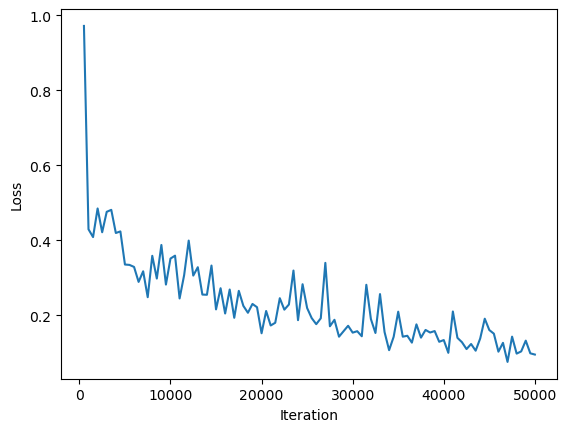

In [21]:
perf_measure
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('BestModelFromEx2ONEx3.png')
plt.show()